# Import Libraries

In [1]:
# Import built-in Python libs
import pickle
from pathlib import Path
from dataclasses import dataclass
from typing import List
import unicodedata

# Import data science libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import weights & bias
import wandb

# Import deep learning libs
import torch
import pytorch_lightning as pl

# Import data preprocessing libs
from tokenizers import Tokenizer, pre_tokenizers, decoders
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.normalizers import NFKC
from tokenizers.processors import TemplateProcessing
from torch.utils.data import Dataset, DataLoader
import fasttext
import jieba
from janome.tokenizer import Tokenizer as ja_tokenizer

---

# Split Raw Dataset to Source and Target datasets

In [4]:
root_dir = Path.cwd().parent
data_dir = root_dir / "dataset" / "ASPEC-JC"

def extract_jp_ch_datasets(txt_arr):
    p = np.array([list(map(str.strip, text.split("|||")[1:])) for text in txt_arr])
    jp = p[:, 0]
    ch = p[:, 1]
    return ch, jp


def split_raw_text(txt_path):
    with txt_path.open() as f:
        ch, jp = extract_jp_ch_datasets(f.readlines())
        
        np.savetxt(txt_path.parent / "ch.txt", ch, fmt="%s")
        np.savetxt(txt_path.parent / "jp.txt", jp, fmt="%s")


dev_txt = data_dir / "dev" / "dev.txt"
devtest_txt = data_dir / "devtest" / "devtest.txt"
test_txt = data_dir / "test" / "test.txt"
train_txt = data_dir / "train" / "train.txt"

# uncomment to run the split program
# split_raw_text(dev_txt)
# split_raw_text(devtest_txt)
# split_raw_text(test_txt)
# split_raw_text(train_txt)

## Log Raw Data Artifacts

In [4]:
run = wandb.init(project='phonetic-translation', 
                 entity='windsuzu',
                 group="dataset",
                 name="raw_data",
                 job_type="data_upload")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
# save raw txt file to artifact
#
# |-- train
#     |-- ch & jp
# |-- dev
#     |-- ch & jp
# |-- devtest
#     |-- ch & jp
# |-- test
#     |-- ch & jp

root_dir = Path.cwd().parent
data_dir = root_dir / "dataset" / "ASPEC-JC"
raw_data_types = ["train", "dev", "devtest", "test"]

artifacts = {}

for data_type in raw_data_types:
    artifacts[data_type] = wandb.Artifact(data_type, "raw_data")
    artifacts[data_type].add_file(data_dir / data_type / "ch.txt", "ch.txt")
    artifacts[data_type].add_file(data_dir / data_type / "jp.txt", "jp.txt")

for data_type, artifact in artifacts.items():
    run.log_artifact(artifact)

---
# Corpus Filtering

In [2]:
run = wandb.init(project='phonetic-translation', 
                 entity='windsuzu',
                 group="dataset",
                 job_type="corpus_filtering")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: windsuzu (use `wandb login --relogin` to force relogin)


In [5]:
# Download Raw Data
train_data_art = run.use_artifact("train:latest")
train_data_dir = train_data_art.download()

# Open Raw Data
with open(Path(train_data_dir) / "ch.txt", encoding="utf8") as f:
    ch_docs = f.readlines()

with open(Path(train_data_dir) / "jp.txt", encoding="utf8") as f:
    jp_docs = f.readlines()

wandb: Downloading large artifact train:latest, 205.64MB. 2 files... Done. 0:0:0


In [7]:
original_parallel_docs = list(zip(ch_docs, jp_docs))
len(original_parallel_docs)

672315

## Define Filtering Functions

In [8]:
PRETRAINED_MODEL_PATH = '../fasttext/lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)


def pass_length_ratio(ch, jp):
    l_r = len(ch) / len(jp)
    return l_r > 0.5 and l_r < 1.4


def pass_length(ch, jp):
    return len(ch) > 5 and len(ch) < 80 and len(jp) > 10 and len(jp) < 100


def pass_same_sentence(ch, jp):
    return ch != jp


def pass_language_identification(ch, jp):
    return model.predict(ch.strip())[0][0] == "__label__zh" and model.predict(jp.strip())[0][0] == "__label__ja"


def pass_imbalance_word(text):
    count = 0
    for c in text.strip():
        try:
            # find the difference between (ch+jp) and (en+num+space)
            if c.encode("ascii").isalpha() or c.isdigit() or c.isspace():
                count += 1
        except:
            pass
    
    actual = len(text) - count
    return actual > count

## Basic Corpus Filtering

1. 刪除長度比例過大的句子
2. 刪除過短或過長的句子
3. 刪除一樣的句子
4. 刪除不能被 fasttext identification model 認出語言的句子
5. 刪除英文、數字符號多於中日文的句子
6. 刪除有多種對應的翻譯的句子


In [9]:
filtered = []
overlap = {}

for ch, jp in original_parallel_docs:
    # change full-width character to half-width
    ch = unicodedata.normalize("NFKC", ch)
    jp = unicodedata.normalize("NFKC", jp)
    
    if not pass_length_ratio(ch, jp):
        continue
    
    if not pass_length(ch, jp):
        continue
    
    if not pass_same_sentence(ch, jp):
        continue
    
    if not pass_language_identification(ch, jp):
        continue
    
    if not pass_imbalance_word(ch) or not pass_imbalance_word(jp):
        continue
    
    if overlap.get(ch) or overlap.get(jp):
        continue
    else:
        overlap[ch] = jp
        overlap[jp] = ch
        
    filtered.append((ch, jp))

len(filtered)

557685

## Word Alignment

### Step 1

把所有的中文和日文句子都用 jieba 和 janome 進行 tokenization，並組合成要丟進 fast_align 模型的格式。

In [13]:
janome = ja_tokenizer()
corpus = []

for ch, jp in filtered:
    ch_str_tokenized = " ".join(jieba.cut(ch[:-1]))
    jp_str_tokenized = " ".join(janome.tokenize(jp[:-1], wakati=True))
    line = f"{ch_str_tokenized} ||| {jp_str_tokenized}\n"
    corpus.append(line)

with open("corpus.zh-ja", 'w', encoding="utf8") as f:
    f.writelines(corpus)

### Step 2

用 fast_align 跑出 `forward.align` 和 `reverse.align` 計算每一句的 word_alignment 分數。

`align` 文件的每一行格式為: `alignment ||| score`

In [59]:
# ./fast_align -i corpus/corpus.zh-ja -d -o -v -s > corpus/forward.align
# ./fast_align -i corpus/corpus.zh-ja -d -o -v -s -r > corpus/reverse.align

with open("../fast_align/corpus/forward.align") as f:
    forward = list(map(lambda x: float(x.split(" ||| ")[1].strip()), f.readlines()))

with open("../fast_align/corpus/reverse.align") as f:
    reverse = list(map(lambda x: float(x.split(" ||| ")[1].strip()), f.readlines()))

### Step 3

刪除機率小於 -160 的句子 (共 96703 句)，目的主要是降低資料集大小。

(array([2.90000e+01, 3.54000e+03, 9.31340e+04, 2.87882e+05, 1.73100e+05]),
 array([-395.466   , -317.093915, -238.72183 , -160.349745,  -81.97766 ,
          -3.605575]),
 <BarContainer object of 5 artists>)

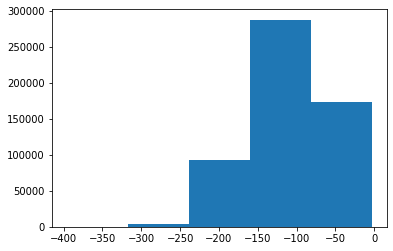

In [87]:
alignment_scores = [sum(score) / 2 for score in zip(forward, reverse)]
plt.hist(alignment_scores, bins=5)

# -3 ~ -81     173100
# -81 ~ -160   287882
#
# -160 ~ -238  93134
# -238 ~ -317  3540
# -317 ~ -395  29

In [90]:
final_filtered = []
for i, score in enumerate(alignment_scores):
    if score > -161:
        final_filtered.append(filtered[i])

In [134]:
len(final_filtered)

462582

In [4]:
root_dir = Path.cwd().parent
data_dir = root_dir / "dataset" / "ASPEC-JC"

ch = np.array(final_filtered)[:, 0]
jp = np.array(final_filtered)[:, 1]

np.savetxt(data_dir / "train" / "filtered_ch.txt", ch, fmt="%s", newline="", encoding="utf8")
np.savetxt(data_dir / "train" / "filtered_jp.txt", jp, fmt="%s", newline="", encoding="utf8")

## Log Filtered Data

In [5]:
filtered_artifact = wandb.Artifact("filtered_train", "filtered_data")

filtered_artifact.add_file(data_dir / "train" / "filtered_ch.txt", "ch.txt")
filtered_artifact.add_file(data_dir / "train" / "filtered_jp.txt", "jp.txt")

run.log_artifact(filtered_artifact)

---

# Google Sentencepiece Tokenization

In [124]:
run = wandb.init(project='phonetic-translation', 
                 entity='windsuzu',
                 group="tokenizer",
                 name="sentence_piece",
                 job_type="build_tokenizer")

In [125]:
# Download Raw Data
train_data_art = run.use_artifact("filtered_train:latest")
train_data_dir = train_data_art.download()

wandb: Downloading large artifact filtered_train:latest, 99.47MB. 2 files... Done. 0:0:0


In [126]:
def sentence_piece_tokenizer(unk_token="[UNK]", dropout: float = None):
    tokenizer = Tokenizer(BPE(dropout=dropout, unk_token=unk_token))
    tokenizer.normalizer = NFKC()
    tokenizer.pre_tokenizer = pre_tokenizers.Sequence(
        [
            pre_tokenizers.Whitespace(),
            pre_tokenizers.Punctuation(),
            pre_tokenizers.Digits(),
            pre_tokenizers.Metaspace(replacement="_", add_prefix_space=True),
        ]
    )

    tokenizer.decoder = decoders.Metaspace(replacement="_", add_prefix_space=True)
    return tokenizer


def train_tokenizer(
    tokenizer,
    files,
    unk_token="[UNK]",
    vocab_size=32000,
    show_progress=True,
    min_frequency=1,
):
    trainer = BpeTrainer(
        special_tokens=[unk_token, "[BOS]", "[EOS]", "[PAD]"],
        vocab_size=vocab_size,
        show_prorgess=show_progress,
        min_frequency=min_frequency,
    )

    if isinstance(files, str):
        files = [files]

    tokenizer.train(files, trainer=trainer)


def build_tokenizer(tokenizer_save_path: str, train_text_path: str, min_frequency=1):
    assert train_text_path.exists(), "Training Raw Text does not exist."

    if not tokenizer_save_path.exists():
        tokenizer = sentence_piece_tokenizer()

        # Train tokenizer
        train_tokenizer(tokenizer, str(train_text_path), min_frequency=min_frequency)

        # Enable Padding
        tokenizer.enable_padding(
            pad_id=tokenizer.token_to_id("[PAD]"), pad_token="[PAD]"
        )

        # Encode => BOS + sentence + EOS
        set_post_processor(tokenizer)

        tokenizer.save(str(tokenizer_save_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_save_path))

    return tokenizer


def set_post_processor(tokenizer):
    tokenizer.post_processor = TemplateProcessing(
        single="[BOS] $A [EOS]",
        special_tokens=[
            ("[BOS]", tokenizer.token_to_id("[BOS]")),
            ("[EOS]", tokenizer.token_to_id("[EOS]")),
        ],
    )

In [127]:
# Get Tokenizer.json File Path

root_dir = Path.cwd().parent
tokenizer_dir = root_dir / "tokenizer"
tokenizer_dir.mkdir(parents=True, exist_ok=True)

ch_tokenizer_dir = tokenizer_dir / "tokenizer_sentencepiece_ch.json"
jp_tokenizer_dir = tokenizer_dir / "tokenizer_sentencepiece_jp.json"

In [129]:
ch_tokenizer = build_tokenizer(ch_tokenizer_dir, Path(train_data_dir) / "filtered_ch.txt", min_frequency=2)
jp_tokenizer = build_tokenizer(jp_tokenizer_dir, Path(train_data_dir) / "filtered_jp.txt", min_frequency=2)

In [130]:
# Print first ten vocab
print([(key, val) for key, val in ch_tokenizer.get_vocab().items()][:10])
print(ch_tokenizer.get_vocab_size())
print()

# Encode and Decode Testing
encoded = ch_tokenizer.encode("缅因州的波特兰拥有Ｒｉｖｅｒｓｉｄｅ循环使用设施（ＲＲＦ）😀")

print(encoded.ids)
print(encoded.tokens)
ch_tokenizer.decode(encoded.ids)

[('传送到', 13975), ('_应当', 24095), ('路', 4527), ('有多个', 15366), ('要高', 13866), ('拉长', 28030), ('的流程', 19359), ('°', 101), ('出席', 19479), ('枪', 2263)]
32000

[1, 66, 3598, 1137, 25173, 2598, 2906, 667, 6265, 20542, 29308, 10185, 5896, 5387, 6432, 5381, 5765, 8231, 5378, 66, 0, 2]
['[BOS]', '_', '缅', '因', '州的', '波', '特', '兰', '拥有', 'Ri', 'vers', 'ide', '循环', '使用', '设施', '_(', '_R', 'RF', '_)', '_', '[UNK]', '[EOS]']


'缅因州的波特兰拥有Riverside循环使用设施 ( RRF ) '

In [131]:
# Print first ten vocab
print([(key, val) for key, val in jp_tokenizer.get_vocab().items()][:10])
print(jp_tokenizer.get_vocab_size())
print()

# Encode and Decode Testing
encoded = jp_tokenizer.encode_batch(["Ｃ＆Ｄ管理施設の高度化", "😀異業種ネットワークからの地域ブランド化"])

for i in range(2):
    print(encoded[i].ids)
    print(encoded[i].tokens)
    print(encoded[i].attention_mask)
    print(jp_tokenizer.decode(encoded[i].ids))
    print()

[('が最も多く', 21270), ('全て', 5789), ('現場で', 22870), ('不満', 29539), ('_合計', 11997), ('_負荷', 10119), ('報酬', 6759), ('契機', 15329), ('二種類の', 21339), ('波の', 13301)]
32000

[1, 3961, 6067, 4144, 4073, 5229, 26146, 716, 2, 3, 3, 3, 3]
['[BOS]', '_C', '_&', '_D', '管理', '施設', 'の高度', '化', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
C & D管理施設の高度化

[1, 63, 0, 9811, 1836, 2511, 4118, 4290, 4720, 361, 8074, 716, 2]
['[BOS]', '_', '[UNK]', '_異', '業', '種', 'ネットワーク', 'からの', '地域', 'ブ', 'ランド', '化', '[EOS]']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 異業種ネットワークからの地域ブランド化



## Log Tokenizer Artifact

In [132]:
artifact = wandb.Artifact("sentencepiece", 
                          type="tokenizer",
                          metadata={"vocab": 32000, 
                                    "method": "SentencePiece",
                                    "min_frequency": 2})

artifact.add_file(ch_tokenizer_dir, "ch_tokenizer.json")
artifact.add_file(jp_tokenizer_dir, "jp_tokenizer.json")
run.log_artifact(artifact)